<a href="https://colab.research.google.com/github/gapself/pjatk/blob/main/Zadanie_4_klasyfikacja_wieloetykietowa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import StratifiedKFold
from statistics import stdev
from sklearn import metrics

from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.multiclass import OneVsRestClassifier

from sklearn.preprocessing import label_binarize

# Podział zbioru treningowego i miary jakości

#### Danijel Koržinek <danijel@pja.edu.pl>

Uruchom poniższy blok:

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=RuntimeWarning)  
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Zacznijmy od wczytania zbioru danych z biblioteki `sklearn.datasets`. Zapisz wynik funkcji `load_breast_cancer` do zmiennej:

In [3]:
from sklearn.datasets import load_breast_cancer
breast_cancer_dataset = load_breast_cancer()

Wypisz wszystkie składowe `keys()` otrzymanego zbioru:

In [4]:
print(breast_cancer_dataset.keys())

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


Zobaczmy składową `DESCR`:

In [5]:
print(breast_cancer_dataset["DESCR"])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

Jest to zbiór przeznaczony do binarnej klasyfikacji rzeczywistych danych liczbowych. Wypisz nazwy cech (`feature_names`) i klas (`target_names`):

In [6]:
print(breast_cancer_dataset["feature_names"])
print(breast_cancer_dataset["target_names"])

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
['malignant' 'benign']


Wypisz rozmiary tablic danych (`data`) i klas (`target`):

In [7]:
print(breast_cancer_dataset["data"].size)
print(breast_cancer_dataset["target"].size)

17070
569


## Podział danych

Użyj metody `train_test_split` z modułu `sklearn.model_selection` żeby podzielić zbiór na część treningową (90%) i testową (10%). Użyj straktyfikacji w podziale danych:

In [8]:
from sklearn.model_selection import train_test_split
X, y = breast_cancer_dataset["data"], breast_cancer_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

Wczytaj następujące klasyfikatory:

```
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
```

Dla każdego klasyfikatora (skonstruowanego domyślnymi parametrami) zastosuj odpowiednio metody `fit` na danych treningowych i `score` na danych testowych żeby otrzymać jego dokładność. Zaleca się zrobić słownik poszczególnych modeli i uruchomić wszystko w pętli `for`. Co się stanie jak zmienimy podział danych (użyjemy metody split ponownie)?


> ***Gdy użyjemy splita ponownie =  nieznacznie zmienią się wyniki dla: MLPClassifier, SGDClassifier***


In [9]:
classifiers = [LinearRegression(),
                GaussianProcessClassifier(),
                GaussianNB(),
                SVC(),
                MLPClassifier(),
                KNeighborsClassifier(),
                SGDClassifier()]

In [10]:
models_dict = {}
for classifier in classifiers:
  classifier.fit(X_train, y_train)
  accuracy = classifier.score(X_test, y_test) # dokładność mojego modelu
  models_dict[classifier] = accuracy
print(models_dict)

{LinearRegression(): 0.6970003216389806, GaussianProcessClassifier(): 0.9298245614035088, GaussianNB(): 0.9824561403508771, SVC(): 0.9298245614035088, MLPClassifier(): 0.9122807017543859, KNeighborsClassifier(): 0.9122807017543859, SGDClassifier(): 0.9473684210526315}


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
for classifier in classifiers:
  classifier.fit(X_train, y_train)
  accuracy = classifier.score(X_test, y_test) 
  models_dict[classifier] = accuracy
print(models_dict)

{LinearRegression(): 0.6970003216389806, GaussianProcessClassifier(): 0.9298245614035088, GaussianNB(): 0.9824561403508771, SVC(): 0.9298245614035088, MLPClassifier(): 0.9122807017543859, KNeighborsClassifier(): 0.9122807017543859, SGDClassifier(): 0.9298245614035088}


## Walidacja krzyżowa

Przy niewielkim zbiorze danych, ciężko jest wydzielić reprezentatywny zbiór testowy. Jeden ze sposobów jest uruchomić cały proces kilka razy i raportować średnie i odchylenia uzyskanych wyników.

Lepszym sposobem jest podzielić cały zbiór danych na `K` paczek i iteracyjnie użyć każdej paczki jako dane testowe, a wszystkie inne (w każdej iteracji) jako dane treningowe.

Użyj klasy `StratifiedKFold` z modułu `sklearn.model_selection` żeby podzielić zbiór na 5 części i powtórz poprzedni eksperyment do liczenia dokładności modeli. Jako wynik podaj wartość średnią i odchylenie standardowe dla wsyzstkich podziałów danego modelu.

In [12]:
skf = StratifiedKFold(n_splits=5)

for classifier in classifiers:
  acc_for_classifier = []
  n_split = 0

  for train_index, test_index in skf.split(X, y):
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    classifier.fit(X_train, y_train)
    accuracy = classifier.score(X_test, y_test) # dokładność mojego modelu
    acc_for_classifier.append(accuracy)
    n_split += 1
    # print("accuracy for split NUM: ", n_split," ", accuracy, "  ", classifier)

  print("--------PODSUMOWANIE DLA KLASYFIKATORA------------", classifier,)
  print("MEAN acc", sum(acc_for_classifier)/5)
  print("STD acc", stdev(acc_for_classifier))
  print("")

--------PODSUMOWANIE DLA KLASYFIKATORA------------ LinearRegression()
MEAN acc 0.7408173313601685
STD acc 0.029987826576265544

--------PODSUMOWANIE DLA KLASYFIKATORA------------ GaussianProcessClassifier()
MEAN acc 0.9068622884645242
STD acc 0.021973671290398487

--------PODSUMOWANIE DLA KLASYFIKATORA------------ GaussianNB()
MEAN acc 0.9385188635305075
STD acc 0.016307637526154637

--------PODSUMOWANIE DLA KLASYFIKATORA------------ SVC()
MEAN acc 0.9121720229777983
STD acc 0.03962723267191617

--------PODSUMOWANIE DLA KLASYFIKATORA------------ MLPClassifier()
MEAN acc 0.9314702685918336
STD acc 0.027286185383730406

--------PODSUMOWANIE DLA KLASYFIKATORA------------ KNeighborsClassifier()
MEAN acc 0.9279459711224964
STD acc 0.024331509914315864

--------PODSUMOWANIE DLA KLASYFIKATORA------------ SGDClassifier()
MEAN acc 0.8945815867101382
STD acc 0.03443814372411696



Naturalnym pytaniem jest jaką wartość wybrać dla parametru `K`. Im więcej paczek użyjemy, tym większa wariancja w wynikach. Dużo paczek oznacza mniejsze ryzyko biasu w eksperymentach, ale testy są robione na mniejszej ilości danych i przez to są bardziej chaotyczne. Mniej paczek oznacza bardziej dokładne wyniki testów, ale jest ryzyko że dane w ustalonych podziałach będa mniej reprezentatywne dla ogółu problemu. W skrajnym przypadku możemy użyć tyle paczek ile jest próbek - ta metoda nazywa się Leave-One-Out.

Powtórz te same eksperymenty co poprzednio używając klasy `LeaveOneOut`, ale dla osczędności czasu użyj tylko jednego klasyfikatora (np SVC):

In [13]:
loo = LeaveOneOut()

acc_for_classifier = []
for train_index, test_index in loo.split(X, y):
  # print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  svm = SVC().fit(X_train, y_train)
  acc = svm.score(X_test, y_test)
  acc_for_classifier.append(acc)

print("MEAN acc for classifier SVC is", sum(acc_for_classifier)/len(X))
print("STD acc for classifier SVC is", stdev(acc_for_classifier))

MEAN acc for classifier SVC is 0.9121265377855887
STD acc for classifier SVC is 0.2833598931225475


## Miary jakości modelu

Wczytaj następujące metody:
```
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
```

Zrób zwykły podział train/test 90/10. Dla wszystkich modeli oprócz regresji liniowej, zastosuj odpowiednio metody `fit` na danych treningowych i `predict` na danych testowych. Potem policz odpowiednio dokładność (`accuracy_score`), precyzję (`precision`), czułóść (`recall`), f-score i macierz konfuzji dla poszczególnych klasyfikatorów. Użyj też metody `classification_report` żeby zobaczyć ogólny raport:

In [14]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report, precision_score, recall_score, f1_score
X, y = breast_cancer_dataset["data"], breast_cancer_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [15]:
classifiers = [ GaussianProcessClassifier(),
                GaussianNB(),
                SVC(),
                MLPClassifier(),
                KNeighborsClassifier(),
                SGDClassifier()]

In [16]:
for classifier in classifiers:
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  train_accuracy_score = accuracy_score(y_test, y_pred)

  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)

  print(classifier,
        "\n   accuracy_score: ", train_accuracy_score,
        "\n   precision: ", precision,
        "\n   recall: ", recall,
        "\n   f1: ", f1,
        "\n   classification_report: ", classification_report(y_test, y_pred)
        )

GaussianProcessClassifier() 
   accuracy_score:  0.9298245614035088 
   precision:  0.9444444444444444 
   recall:  0.9444444444444444 
   f1:  0.9444444444444444 
   classification_report:                precision    recall  f1-score   support

           0       0.90      0.90      0.90        21
           1       0.94      0.94      0.94        36

    accuracy                           0.93        57
   macro avg       0.92      0.92      0.92        57
weighted avg       0.93      0.93      0.93        57

GaussianNB() 
   accuracy_score:  0.9824561403508771 
   precision:  0.972972972972973 
   recall:  1.0 
   f1:  0.9863013698630138 
   classification_report:                precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.97      1.00      0.99        36

    accuracy                           0.98        57
   macro avg       0.99      0.98      0.98        57
weighted avg       0.98      0.98      0.98       

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


## ROC i AUC

Użyj wszystkich modeli oprócz regresji liniowej i GPC, a dla SVC dodaj parametr `probability=True`. Użyj walidacji krzyżowej żeby wytrenować każdy z modeli i policzyć `predict_proba` dla całego zbioru. Potem policz `roc_curve` i `auc_score` dla wszystkich modeli i narysuj na wykresie. 

Najpierw użyj tych poleceń żeby otrzymać pusty wykres ROC:

```
figure(figsize=(5,5))
plot([0,1],[0,1],color='black',lw=2,linestyle='--')
xlabel('1 - specificity')
ylabel('sensitivity')
title('ROC')
```

Dla każdego klasyfikatora użyj metody `plot` żeby narysować wartości `x=fpr` i `y=tpr` z metody `roc_curve`, a jako `label` ustaw nazwę modelu i jego `AUC`. Na końcu uruchom metodę `legend(loc='lower right')` żeby narysować legendę w dolnym prawym rogu wykresu.

In [17]:
classifiers = [ GaussianNB(),
                SVC(probability=True),
                MLPClassifier(),
                KNeighborsClassifier(),
                SGDClassifier(loss='modified_huber')]

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

--------PODSUMOWANIE DLA KLASYFIKATORA------------ GaussianNB()
MEAN acc 0.9385188635305075
STD acc 0.016307637526154637
AUC: 0.9873683530987822
(456, 30) (113, 30) (456,) (113,)


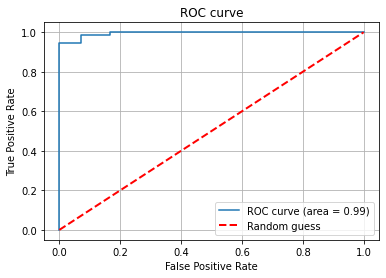


--------PODSUMOWANIE DLA KLASYFIKATORA------------ SVC(probability=True)
MEAN acc 0.9121720229777983
STD acc 0.03962723267191617
AUC: 0.973961923998773
(456, 30) (113, 30) (456,) (113,)


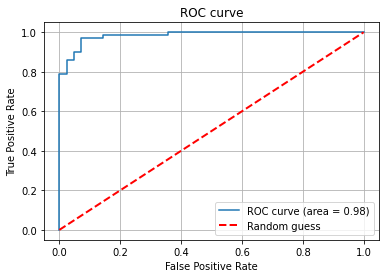


--------PODSUMOWANIE DLA KLASYFIKATORA------------ MLPClassifier()
MEAN acc 0.9156342182890855
STD acc 0.018230563564018674
AUC: 0.9719350556396085
(456, 30) (113, 30) (456,) (113,)


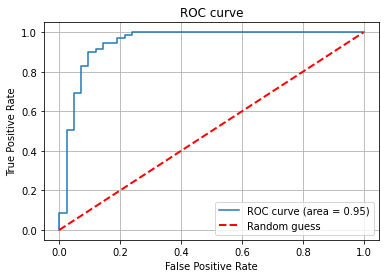


--------PODSUMOWANIE DLA KLASYFIKATORA------------ KNeighborsClassifier()
MEAN acc 0.9279459711224964
STD acc 0.024331509914315864
AUC: 0.9596258645759136
(456, 30) (113, 30) (456,) (113,)


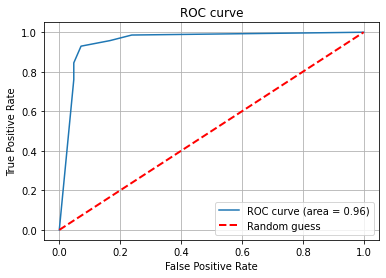


--------PODSUMOWANIE DLA KLASYFIKATORA------------ SGDClassifier(loss='modified_huber')
MEAN acc 0.8083372147182114
STD acc 0.11865811921714103
AUC: 0.8156356745121893
(456, 30) (113, 30) (456,) (113,)


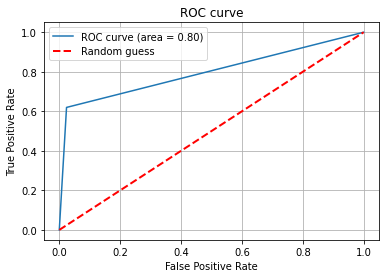

In [18]:
skf = StratifiedKFold(n_splits=5)

for classifier in classifiers:
  acc_for_classifier = []
  auc_list = []

  for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    classifier.fit(X_train, y_train)

    accuracy = classifier.score(X_test, y_test)
    acc_for_classifier.append(accuracy)

    predY = classifier.predict_proba(X_test)
    fpr, tpr, thresh = metrics.roc_curve(y_test, predY[:,1])
    auc = metrics.auc(fpr, tpr)
    auc_list.append(auc)

  predict_proba = sum(acc_for_classifier)/5

  print("--------PODSUMOWANIE DLA KLASYFIKATORA------------", classifier,)
  print("MEAN acc", predict_proba)
  print("STD acc", stdev(acc_for_classifier))
  print("AUC:", sum(auc_list)/5)
  print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
  plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' %auc)
  plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
  plt.title('ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.grid()
  plt.legend()
  plt.show()
  print("")

# Zadanie 1. -- Klasyfikacja wieloetykietowa

Powtórz powyższe zadania na zbiorze danych win uzyskanego metodą `load_wine` z modułu `sklearn.datasets`. Warto zwrócić uwagę, że ten zbiór definiuje 3 różne klasy.

Użyj `sklearn.multiclass.OneVsRestClassifier` żeby zastosować poprzednie klasyfikatory na nowych danych.

Przy liczeniu krzywy ROC i wartości AUC użyj `sklearn.preprocessing.label_binarize` na referncji i metody `ravel()` na macierzach wyjściowych przed narysowaniem.

https://rasbt.github.io/mlxtend/user_guide/data/wine_data/

In [19]:
from sklearn.datasets import load_wine

wide_dataset = load_wine()

print(wide_dataset.keys())

X, y = wide_dataset["data"], wide_dataset["target"]
print(wide_dataset["data"].size)
print(wide_dataset["target"].size)

print(wide_dataset["feature_names"])
print(wide_dataset["target_names"])

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names'])
2314
178
['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
['class_0' 'class_1' 'class_2']


In [20]:
classifiers = [ GaussianNB(),
                SVC(probability=True),
                MLPClassifier(),
                KNeighborsClassifier(),
                SGDClassifier(loss='modified_huber')]

--------PODSUMOWANIE DLA KLASYFIKATORA------------ GaussianNB()
MEAN acc 0.9607936507936508
STD acc 0.014928231770859033
AUC: 1.0
(143, 13) (35, 13) (143,) (35, 3)


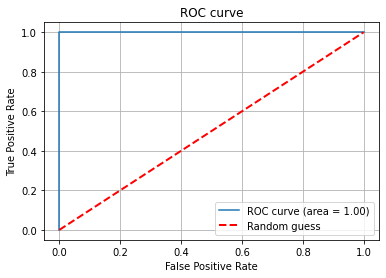


--------PODSUMOWANIE DLA KLASYFIKATORA------------ SVC(probability=True)
MEAN acc 0.6857142857142857
STD acc 0.03839580502197427
AUC: 1.0
(143, 13) (35, 13) (143,) (35, 3)


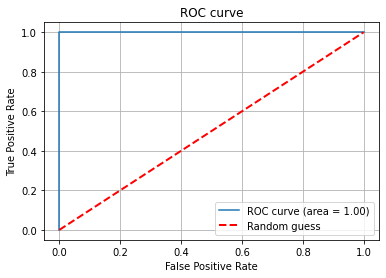

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


--------PODSUMOWANIE DLA KLASYFIKATORA------------ MLPClassifier()
MEAN acc 0.5803174603174603
STD acc 0.16324376275097774
AUC: 1.0
(143, 13) (35, 13) (143,) (35, 3)


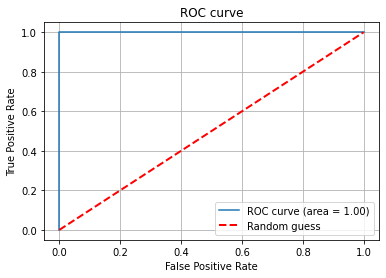


--------PODSUMOWANIE DLA KLASYFIKATORA------------ KNeighborsClassifier()
MEAN acc 0.6915873015873016
STD acc 0.07412800379979148
AUC: 1.0
(143, 13) (35, 13) (143,) (35, 3)


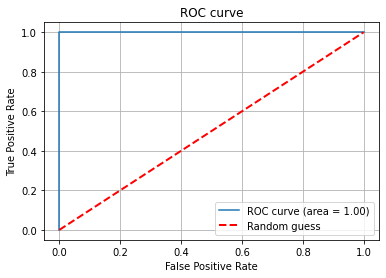


--------PODSUMOWANIE DLA KLASYFIKATORA------------ SGDClassifier(loss='modified_huber')
MEAN acc 0.5674603174603174
STD acc 0.06394678437613868
AUC: 1.0
(143, 13) (35, 13) (143,) (35, 3)


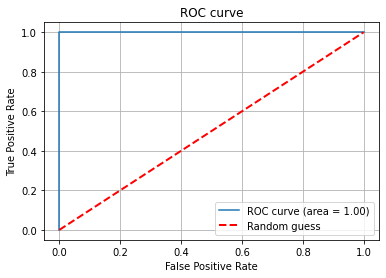

In [24]:
skf = StratifiedKFold(n_splits=5)

for classifier in classifiers:
  acc_for_classifier = []
  auc_list = []

  for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = OneVsRestClassifier(classifier)
    model.fit(X_train, y_train)

    accuracy = model.score(X_test, y_test)
    acc_for_classifier.append(accuracy)

    predY = model.predict_proba(X_test)
    y_test = label_binarize(y_test, classes=[0,1,2])
    predY = label_binarize(y_test, classes=[0,1,2])
    
    fpr, tpr, thresh = roc_curve(y_test.ravel(), predY.ravel())
    auc = metrics.auc(fpr, tpr)
    auc_list.append(auc)

  predict_proba = sum(acc_for_classifier)/5

  print("--------PODSUMOWANIE DLA KLASYFIKATORA------------", classifier,)
  print("MEAN acc", predict_proba)
  print("STD acc", stdev(acc_for_classifier))
  print("AUC:", sum(auc_list)/5)
  print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
  plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' %auc)
  plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
  plt.title('ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.grid()
  plt.legend()
  plt.show()
  print("")

# Zadanie 2. -- Optymalizacja hiperparametru

Użyj podwójnej walidacji krzyżowej żeby znaleźć średnią skuteczność klasyfikatora SVC (na danych `load_breast_cancer`) dla optymalnego parametru `C`.

Należy użyć podwójnej metody K-Fold: najpierw dzielimy zbiór na train/test, a potem w każdej iteracji zbiór train dodatowko dzielimy na train/dev kolejną pętlą walidacji krzyżowej. Za pomocą podziału train/dev szukamy jaki parametr `C` daje najlepszy wynik (załóżmy że przetestujemy ~10 różnych wartości równomiernie rozłożonych od 0.2 do 2 ), a potem użyjemy tą optymalną wartość żeby dokonać eksperymentu na zbiorze test.